前置設定

In [18]:
# ===== 基礎 =====
import os, re, numpy as np, pandas as pd
from scipy import sparse as sp
from bs4 import BeautifulSoup

# Sklearn
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag, word_tokenize, ne_chunk

# 其他
from joblib import Parallel, delayed
from math import ceil

# ===== 路徑與隨機種子 =====
DATA_DIR = './dataset'
TRAIN_PATH = f'{DATA_DIR}/train.csv'
TEST_PATH  = f'{DATA_DIR}/test.csv'
OUT_DIR = './output'
os.makedirs(OUT_DIR, exist_ok=True)
np.random.seed(42)

# ===== 速度開關（訓練時可先關慢模塊）=====
FAST_NO_NER = True        # 關 NER
FAST_NO_LDA = False        # 關 LDA 主題
FAST_NO_TEXTSTAT = True   # 關可讀性評分

# ===== NLTK 資源（缺什麼補什麼）=====
for rid, name in [
    ('tokenizers/punkt', 'punkt'),
    ('corpora/stopwords', 'stopwords'),
    ('corpora/wordnet', 'wordnet'),
    ('sentiment/vader_lexicon', 'vader_lexicon'),
    ('taggers/averaged_perceptron_tagger', 'averaged_perceptron_tagger'),
    ('chunkers/maxent_ne_chunker', 'maxent_ne_chunker'),
    ('corpora/words', 'words'),
]:
    try:
        nltk.data.find(rid)
    except LookupError:
        nltk.download(name)

# 全局 VADER（避免每條樣本重建）
try:
    VADER = SentimentIntensityAnalyzer()
except Exception:
    VADER = None


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


導入數據與切分

In [19]:
# 將 Popularity {-1,1} → {0,1}；並切出 train/val
df_all = pd.read_csv(TRAIN_PATH)
df_all['Popularity'] = (df_all['Popularity'].astype(int) == 1).astype(int)

TRAIN_SIZE = 24000
VAL_SIZE   = 3000

train_df = df_all.iloc[:TRAIN_SIZE].reset_index(drop=True)
val_df   = df_all.iloc[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE].reset_index(drop=True)

print(train_df.shape, val_df.shape)
train_df.head(2)


(24000, 3) (3000, 3)


,Id,Popularity,Page content
0,0,0,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."


工具函數

In [20]:
# 小工具
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    if n is None: return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h: return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h: return 'unk'
    area = (w or 0) * (h or 0)
    if area < 80_000: return 'xs'
    if area < 230_000: return 'sm'
    if area < 920_000: return 'md'
    if area < 2_100_000: return 'lg'
    return 'xl'

def _parse_wh_from_src(src: str):
    if not src: return (None, None)
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    return (int(m.group(1)), int(m.group(2))) if m else (None, None)

TRENDING_TOPICS = {
    'elon_musk', 'ai', 'climate_change', 'covid', 'blockchain', 'taiwan',
    'tesla', 'space', 'crypto', 'elections'
}

# 修改：启用LDA和其他特征
FAST_NO_LDA = False        # 打开LDA
FAST_NO_NER = False        # 打开NER
FAST_NO_TEXTSTAT = False   # 打开文本统计

# LDA（可選）
def pretrain_lda(df, column='Page content', n_components=15, max_features=2000, max_text_len=500):
    def extract_text(html):
        if not isinstance(html, str) or not html.strip(): return ""
        m = _BODY_OPEN.search(html)
        header_html = html[:m.start()] if m else html
        soup = BeautifulSoup(header_html, 'html.parser')
        return ' '.join(soup.get_text().lower().split()[:max_text_len])

    corpus = [extract_text(x) for x in df[column].astype(str)]
    if not any(corpus): return None, None
    vec = CountVectorizer(max_features=max_features, stop_words='english')
    X = vec.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(X)
    return vec, lda

if not FAST_NO_LDA:
    _df_lda = df_all.dropna(subset=['Page content']).astype({'Page content':'str'})
    lda_vectorizer, lda_model = pretrain_lda(_df_lda, 'Page content', n_components=15, max_features=2000)
    print("LDA pretrained with 15 topics and 2000 features")
else:
    print("LDA skipped by FAST_NO_LDA=True")
    lda_vectorizer, lda_model = None, None

LDA pretrained with 15 topics and 2000 features


預處理函數

In [21]:
# ====== 幫助函數：清洗文本做詞袋 ======
porter = PorterStemmer()
STOP = set(stopwords.words('english'))

def _bow_clean(txt: str) -> str:
    toks = [w for w in re.findall(r'[A-Za-z]+', (txt or '').lower()) if w not in STOP]
    return ' '.join(porter.stem(w) for w in toks)

# 新增：头条分析函数 - 检查是否包含引人注目的元素
def analyze_headline_features(title_text):
    """分析标题中包含的吸引眼球的元素"""
    features = []
    
    # 数字和统计
    if re.search(r'\d+', title_text):
        features.append('has_numbers')
    
    # 检查是否为列表式标题
    if re.match(r'^\s*\d+\s', title_text) or re.search(r'\d+\s+ways|reasons|tips|tricks|facts', title_text, re.I):
        features.append('is_listicle')
    
    # 标点符号
    if '?' in title_text:
        features.append('has_question')
    if '!' in title_text:
        features.append('has_exclamation')
    if ':' in title_text:
        features.append('has_colon')
    
    # 具有吸引力的词汇
    clickbait_words = ['secret', 'shocking', 'amazing', 'surprising', 'unbelievable', 'incredible', 'you won\'t believe', 
                      'mind-blowing', 'this is why', 'here\'s why', 'must see', 'must read', 'need to know']
    
    for word in clickbait_words:
        if word in title_text.lower():
            features.append(f'clickbait_word_{word.replace(" ", "_")}')
    
    # 检查标题长度
    word_count = len(title_text.split())
    if word_count < 5:
        features.append('title_very_short')
    elif word_count > 12:
        features.append('title_very_long')
    else:
        features.append('title_optimal_length')
        
    # 检查是否使用所有大写(喊叫式标题)
    if re.search(r'[A-Z]{3,}', title_text):
        features.append('has_caps_words')
        
    # 检查引号使用(通常表示直接引述，增加可信度)
    if '"' in title_text or "'" in title_text:
        features.append('has_quotes')
        
    return features

# 新增：检测内容时效性的函数
def detect_timeliness(text):
    """检测内容是否具有时效性特征"""
    timeliness_indicators = [
        'breaking', 'just in', 'update', 'latest', 'happening now', 'live',
        'exclusive', 'first', 'developing story', 'this morning', 'this afternoon',
        'today', 'yesterday', 'last night', 'last week', 'recent', 'upcoming',
        'minutes ago', 'hours ago', 'days ago'
    ]
    
    count = 0
    for indicator in timeliness_indicators:
        if indicator in text.lower():
            count += 1
    
    return count

# 新增：词语共现特征提取函数
def extract_word_cooccurrences(text, top_words=50):
    words = [w.lower() for w in re.findall(r'[A-Za-z]+', text) if w.lower() not in STOP]
    if len(words) < 5:
        return []
    
    pairs = []
    for i in range(len(words)-1):
        pairs.append((words[i], words[i+1]))
    
    # 计算最常见的词对
    pair_count = {}
    for pair in pairs:
        pair_str = f"{pair[0]}_{pair[1]}"
        pair_count[pair_str] = pair_count.get(pair_str, 0) + 1
    
    # 返回最常见的词对作为特征
    return [f"pair_{p}" for p, _ in sorted(pair_count.items(), key=lambda x: x[1], reverse=True)[:min(top_words, len(pair_count))]]

# 新增：视觉元素分析函数
def analyze_visual_elements(soup):
    """分析文章中的视觉元素特征，对受欢迎程度有重要影响"""
    features = []
    
    # 图片分析
    imgs = soup.find_all('img')
    if imgs:
        features.append(f'img_count_{len(imgs)}')
        
        # 查找文章顶部的大图
        header_img = False
        for img in imgs[:2]:  # 检查前两个图片
            parent = img.parent
            while parent and parent.name not in ['body', 'html']:
                if parent.name in ['header', 'div'] and ('header' in parent.get('class', []) or 'hero' in parent.get('class', [])):
                    header_img = True
                    break
                parent = parent.parent
        
        if header_img:
            features.append('has_header_image')
            
        # 分析图片位置分布
        positions = []
        for i, img in enumerate(imgs):
            pos = i / max(1, len(imgs))
            positions.append(pos)
        
        if positions:
            even_distribution = np.std(positions) < 0.2
            if even_distribution:
                features.append('evenly_distributed_images')
    
    # 视频内容
    videos = soup.find_all('video')
    iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)
    
    if has_video:
        features.append('has_video')
        # 查找视频位置
        if videos or iframes:
            first_pos = None
            for element in videos + iframes:
                try:
                    content = soup.get_text()
                    element_pos = content.find(element.get_text()) / len(content) if content else None
                    if element_pos and (first_pos is None or element_pos < first_pos):
                        first_pos = element_pos
                except:
                    pass
            
            if first_pos is not None:
                if first_pos < 0.2:
                    features.append('video_at_top')
                elif first_pos < 0.5:
                    features.append('video_in_first_half')
    
    # 交互元素
    interactive_elements = soup.find_all(['canvas', 'svg', 'button', 'input', 'form', 
                                         lambda tag: tag.name=='div' and 'interactive' in (tag.get('class') or [])])
    if interactive_elements:
        features.append(f'interactive_count_{len(interactive_elements)}')
    
    return features

# 新增：内容结构特征分析
def analyze_content_structure(soup):
    """分析文章结构特征，如段落长度，标题分布等"""
    features = []
    
    # 分析段落
    paragraphs = soup.find_all('p')
    if paragraphs:
        p_lengths = [len(p.get_text().split()) for p in paragraphs if p.get_text().strip()]
        if p_lengths:
            avg_p_length = sum(p_lengths) / len(p_lengths)
            features.append(f'avg_p_length_{_bucket(avg_p_length, [0, 15, 30, 60])}')
            
            # 段落一致性 - 检查段落长度是否均匀
            p_std = np.std(p_lengths)
            p_mean = np.mean(p_lengths)
            if p_std/p_mean < 0.5 and len(paragraphs) > 3:
                features.append('consistent_paragraphs')
            elif p_std/p_mean > 1.0:
                features.append('varied_paragraphs')
    
    # 分析小标题
    subheadings = soup.find_all(['h2', 'h3'])
    if subheadings:
        features.append(f'subheading_count_{len(subheadings)}')
        
        # 标题间距
        if len(subheadings) > 1:
            positions = []
            for heading in subheadings:
                try:
                    content = soup.get_text()
                    heading_pos = content.find(heading.get_text()) / len(content) if content else None
                    if heading_pos:
                        positions.append(heading_pos)
                except:
                    pass
            
            if len(positions) > 1:
                intervals = [positions[i+1] - positions[i] for i in range(len(positions)-1)]
                avg_interval = sum(intervals) / len(intervals)
                if 0.1 < avg_interval < 0.3 and np.std(intervals) < 0.1:
                    features.append('regular_subheading_spacing')
    
    # 文章结构元素
    lists = soup.find_all(['ul', 'ol'])
    if lists:
        features.append(f'list_count_{len(lists)}')
    
    blockquotes = soup.find_all('blockquote')
    if blockquotes:
        features.append(f'quote_count_{len(blockquotes)}')
    
    return features

# 新增：社交分享与参与度特征
def analyze_social_engagement(soup, text_content):
    """分析社交分享按钮和参与度指标"""
    features = []
    
    # 社交媒体按钮
    social_patterns = [
        r'(?:share|follow)(?:\s+us)?(?:\s+on)?(?:\s+(?:facebook|twitter|instagram|linkedin|pinterest|reddit|youtube))',
        r'(?:facebook|twitter|instagram|linkedin|pinterest|reddit|youtube)(?:\s+share|\s+button)',
        r'(?:like|tweet|pin|share)(?:\s+this|\s+post|\s+article)',
        r'social(?:\s+share|\s+buttons|\s+media)'
    ]
    
    social_count = 0
    for pattern in social_patterns:
        social_count += len(re.findall(pattern, text_content, re.I))
    
    # 从HTML元素中查找社交按钮
    social_elements = soup.find_all(['a', 'button', 'div'], class_=lambda c: c and any(
        social in c.lower() for social in ['share', 'social', 'facebook', 'twitter', 'instagram', 'linkedin']))
    social_count += len(social_elements)
    
    if social_count > 0:
        features.append(f'social_button_count_{_bucket(social_count, [1, 3, 5, 10])}')
    
    # 评论系统
    comment_elements = soup.find_all(['div', 'section'], id=lambda i: i and 'comment' in i.lower())
    comment_elements += soup.find_all(['div', 'section'], class_=lambda c: c and 'comment' in c.lower())
    
    if comment_elements:
        features.append('has_comment_section')
    
    # 查找评论计数
    comment_count_patterns = [r'(\d+)(?:\s+)?(?:comment|reply|response)', r'(?:comment|reply|response)(?:s)?(?:\s+)?(?:\(|:)?(\d+)']
    comment_counts = []
    
    for pattern in comment_count_patterns:
        for match in re.finditer(pattern, text_content, re.I):
            try:
                count = int(match.group(1))
                comment_counts.append(count)
            except:
                pass
    
    if comment_counts:
        features.append(f'comment_count_{_bucket(max(comment_counts), [0, 10, 50, 100, 500])}')
    
    return features

# 新增：主题相关性和热点话题检测
def detect_trending_topics(text_content):
    """检测文章是否包含热门话题和时下流行话题"""
    features = []
    
    # 扩展热门话题列表
    trending_topics = TRENDING_TOPICS.union({
        'pandemic', 'vaccine', 'ukraine', 'russia', 'inflation', 'economy', 
        'bitcoin', 'metaverse', 'gpt', 'chatgpt', 'openai', 'tiktok',
        'instagram', 'facebook', 'meta', 'google', 'apple', 'microsoft',
        'amazon', 'netflix', 'streaming', 'smartphone', 'iphone', 'android',
        'election', 'politics', 'biden', 'trump', 'china', 'climate'
    })
    
    # 检测热门话题
    topic_matches = [topic for topic in trending_topics 
                     if topic.replace('_', ' ') in text_content.lower()]
    
    if topic_matches:
        features.append(f'trending_topic_count_{_bucket(len(topic_matches), [1, 2, 5, 10])}')
        # 添加前3个匹配的话题作为特征
        for topic in topic_matches[:3]:
            features.append(f'trend_{topic}')
    
    return features

# ====== ★★★ 重新设计的 preprocessor：专注新闻受欢迎度特征 ★★★ ======
def preprocessor(html: str, lda_vectorizer=None, lda_model=None, max_text_len=500):
    if not isinstance(html, str) or not html.strip():
        # ★ 回傳 6 個空值
        return "empty_content", set(), "", "", "", ""

    # ★ 將 HTML 分為 header 和 body
    m = _BODY_OPEN.search(html)
    if m:
        header_html = html[:m.start()]
        body_html = html[m.start():]
    else:
        header_html = html
        body_html = ""

    soup = BeautifulSoup(header_html, 'html.parser')

    # --- [原有的 header 特徵提取代碼，保持不變] ---
    # 標題
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1: title_raw = h1.get_text(' ', strip=True)
    elif soup.title: title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者 / 頻道 / 發佈者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by: author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a: author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'): channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub: publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 時間 - 对新闻时效性非常重要
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt);  year = y.group(1) if y else None
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd: weekday = wd.group(1).lower(); is_weekend = weekday in ('sat','sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5<=h<12 else 'afternoon' if 12<=h<17 else 'evening' if 17<=h<22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3<=m_i<=5 else 'summer' if 6<=m_i<=8 else 'autumn' if 9<=m_i<=11 else 'winter'
            
    # --- [开始：重新设计的特征] ---
    
    # 获取页面文本内容
    text_content = soup.get_text(' ', strip=True).lower()
    
    # 1. 标题特征分析 - 新闻标题是受欢迎度的关键指标
    headline_features = []
    if title_raw:
        headline_features = analyze_headline_features(title_raw)
    
    # 2. 视觉元素分析 - 图片和视频是新闻受欢迎度的重要指标
    visual_features = analyze_visual_elements(soup)
    
    # 3. 内容结构分析
    structure_features = []
    body_soup = None
    if body_html:
        body_soup = BeautifulSoup(body_html, 'html.parser')
        structure_features = analyze_content_structure(body_soup)
    
    # 4. 社交分享与参与度分析
    social_features = analyze_social_engagement(soup, text_content)
    
    # 5. 时效性特征分析 - 对新闻很重要
    timeliness_score = detect_timeliness(text_content)
    timeliness_features = [f'timeliness_score_{_bucket(timeliness_score, [0, 1, 3, 5])}']
    if timeliness_score > 2:
        timeliness_features.append('high_timeliness')
    
    # 6. 热点话题检测
    trending_features = detect_trending_topics(text_content)
    
    # 7. 话题分析 (LDA) - 保留原有功能，对新闻主题分类有帮助
    topic_features = []
    if ('FAST_NO_LDA' not in globals() or not FAST_NO_LDA) and (lda_vectorizer is not None) and (lda_model is not None):
        X_ = lda_vectorizer.transform([text_content] if text_content else [''])
        topic_dist = lda_model.transform(X_)
        dom = int(np.argmax(topic_dist[0])) if topic_dist.size>0 else 0
        score = float(topic_dist[0][dom]) if topic_dist.size>0 else 0.0
        topic_features = [f'topic_{dom}_b{_bucket(score,[0,0.5,0.7,0.9])}']
    else:
        topic_features = ['topic_unk']
    
    # 8. 可读性分析 - 简化，只保留关键指标
    readability_features = []
    if 'FAST_NO_TEXTSTAT' not in globals() or not FAST_NO_TEXTSTAT:
        try:
            from textstat import flesch_reading_ease, gunning_fog
            readability_score = flesch_reading_ease(text_content) if text_content else 0
            fog_score = gunning_fog(text_content) if text_content else 0
            
            readability_bucket = ('very_easy' if readability_score>80 else
                                'easy' if readability_score>60 else
                                'standard' if readability_score>50 else
                                'difficult' if readability_score>30 else 'very_difficult')
            
            readability_features = [
                f'readability_{readability_bucket}',
                f'fog_index_{_bucket(fog_score, [6, 10, 14, 18])}'
            ]
        except Exception:
            readability_features = ['readability_standard']
    else:
        readability_features = ['readability_standard']
    
    # 9. 网页结构特征 - 保留原有功能的简化版
    div_count = len(soup.find_all('div'))
    section_count = len(soup.find_all('section'))
    list_count = len(soup.find_all(['ul','ol']))
    layout_features = [
        f'div_count_{_bucket(div_count, [0,10,30,50,100])}',
        f'section_count_{_bucket(section_count, [0,1,3,5])}',
        f'list_count_{_bucket(list_count, [0,1,3,5])}'
    ]
    
    # 10. 内容长度特征 - 新闻长度也是影响受欢迎程度的重要因素
    header_word_count = len(text_content.split())
    length_features = [f'header_word_count_{_bucket(header_word_count, [0,50,100,200,500])}']
    
    if body_soup:
        body_text = body_soup.get_text(' ', strip=True)
        body_word_count = len(body_text.split())
        length_features.append(f'body_word_count_{_bucket(body_word_count, [0,100,300,600,1000])}')
        
        # 文章总长度
        total_word_count = header_word_count + body_word_count
        length_features.append(f'total_word_count_{_bucket(total_word_count, [0,200,500,1000,2000])}')
    
    # 合并所有特征
    entities = set()  # 简化实体识别，只保留必要的名称实体
    if 'FAST_NO_NER' not in globals() or not FAST_NO_NER:
        try:
            tokens = word_tokenize(text_content[:1000])  # 限制处理长度提高效率
            tagged = pos_tag(tokens)
            from nltk import ne_chunk
            chunked = ne_chunk(tagged)
            for ch in chunked:
                if hasattr(ch,'label') and ch.label() in ['PERSON','ORGANIZATION']:  # 只保留人名和组织
                    ent = '_'.join(c[0].lower() for c in ch)
                    entities.add(f'entity_{ent}')
        except Exception:
            pass
    
    # 合并所有特征组为header_feats
    all_features = []
    all_features.extend([f'author_{author_slug or "unknown"}', f'channel_{channel_slug}', f'publisher_{publisher_slug}'])
    all_features.extend([f'year_{year or "unk"}', f'month_{month or "unk"}', f'weekday_{weekday or "unk"}', f'tod_{tod or "unk"}'])
    all_features.append('weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk')
    
    all_features.extend(headline_features)
    all_features.extend(visual_features)
    all_features.extend(social_features)
    all_features.extend(timeliness_features)
    all_features.extend(trending_features)
    all_features.extend(topic_features)
    all_features.extend(readability_features)
    all_features.extend(layout_features)
    all_features.extend(length_features)
    
    header_feats = ' '.join(all_features)
    
    # 针对body特征
    body_feats = []
    if body_soup:
        # 正文内容特征
        body_feats.extend(structure_features)
        body_text = body_soup.get_text(' ', strip=True)
        
        # 新增：段落和句子分析
        paragraphs = body_soup.find_all('p')
        if paragraphs:
            p_count = len(paragraphs)
            body_feats.append(f'p_count_{_bucket(p_count, [0, 5, 10, 20, 40])}')
            
            # 段落密度分析
            if body_word_count > 0 and p_count > 0:
                words_per_paragraph = body_word_count / p_count
                body_feats.append(f'words_per_p_{_bucket(words_per_paragraph, [10, 30, 60, 100])}')
        
        # 提取词语共现特征
        cooccur_features = extract_word_cooccurrences(body_text, top_words=10)
        body_feats.extend(cooccur_features[:5])  # 限制为前5个最常见词对
        
        # 正文词袋文本
        body_bow_text = _bow_clean(body_text)
    else:
        # 如果没有正文
        body_feats.append('no_body')
        body_bow_text = ""
    
    # 标题和标头的词袋文本
    header_bow_text = _bow_clean(text_content)
    
    # ★ 回傳 6 個值 (与原函数保持一致的接口)
    return _norm(title_tokens), entities, header_feats, header_bow_text, ' '.join(body_feats), body_bow_text

把驗證集轉成特徵，後面評估直接用

In [22]:
# 一次性把驗證集轉成特徵，後面評估直接用
X_val = featurize_split(val_df['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
y_val = val_df['Popularity'].values
sp.save_npz(f'{OUT_DIR}/X_val_split.npz', X_val)
np.save(f'{OUT_DIR}/y_val.npy', y_val)
X_val.shape, np.bincount(y_val)


((3000, 2496512), array([1524, 1476], dtype=int64))

訓練

In [30]:
# 建訓練生成器
BATCH_SIZE = 200  # 适当大的批量大小，提高训练效率
def train_streamer(df, batch_size):
    for i in range(0, len(df), batch_size):
        yield df.iloc[i:i+batch_size]

# 使用类别权重平衡数据
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0,1])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['Popularity'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 新闻受欢迎度预测的优化SGD分类器
# - 使用log_loss以获得更好的概率预测
# - 选择适当的正则化强度和L1比例
# - 使用elastic net正则化来同时进行特征选择和防止过拟合
clf = SGDClassifier(
    loss="log_loss",  
    penalty="elasticnet", 
    alpha=1e-6,  # 降低正则化强度，允许捕获更多有用的特征
    l1_ratio=0.15,  # 降低L1比例，保留更多有信息的特征
    learning_rate="optimal",  # 自适应学习率
    eta0=0.01,  # 初始学习率提高
    power_t=0.25,  # 学习率衰减参数
    average=True,  # 使用权重平均减少方差
    max_iter=1, 
    tol=None, 
    class_weight=class_weight_dict,  # 使用类别权重平衡
    random_state=628
)

EVAL_EVERY = 1  # 每个批次后评估一次
train_auc_hist, val_auc_hist = [], []

# 训练SGD分类器
stream = train_streamer(train_df, BATCH_SIZE)
iters = ceil(len(train_df)/BATCH_SIZE)

for i, batch in enumerate(stream, start=1):
    Xtr = featurize_split(batch['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
    ytr = batch['Popularity'].values
    if i == 1: clf.partial_fit(Xtr, ytr, classes=classes)
    else:      clf.partial_fit(Xtr, ytr)

    # 批內 AUC
    if np.unique(ytr).size == 2:
        if hasattr(clf, 'predict_proba'):
            tr_auc = roc_auc_score(ytr, clf.predict_proba(Xtr)[:, 1])
        else:
            tr_auc = roc_auc_score(ytr, clf.decision_function(Xtr))
    else:
        tr_auc = np.nan
    train_auc_hist.append(tr_auc)

    # 週期性評估（用預計算 X_val）
    if i % EVAL_EVERY == 0 or i == iters:
        if hasattr(clf, 'predict_proba'):
            va_auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
        else:
            va_auc = roc_auc_score(y_val, clf.decision_function(X_val))
        val_auc_hist.append(va_auc)
        print(f"[{i}/{iters}] Train AUC={tr_auc:.4f} | Val AUC={va_auc:.4f}")
    else:
        print(f"[{i}/{iters}] Train AUC={tr_auc:.4f}")

# 保存模型與（可選）LDA組
import _pickle as pkl
pkl.dump(clf, open(f'{OUT_DIR}/clf-sgd-news.pkl','wb'))
pkl.dump({'lda_vec': lda_vectorizer, 'lda_model': lda_model}, open(f'{OUT_DIR}/lda.pkl','wb'))
print("Model saved:", f'{OUT_DIR}/clf-sgd-news.pkl')

[1/120] Train AUC=0.8083 | Val AUC=0.4969
[2/120] Train AUC=0.6571 | Val AUC=0.5093
[3/120] Train AUC=0.6712 | Val AUC=0.5174
[4/120] Train AUC=0.5955 | Val AUC=0.5263
[5/120] Train AUC=0.6364 | Val AUC=0.5349
[6/120] Train AUC=0.5521 | Val AUC=0.5389
[7/120] Train AUC=0.5841 | Val AUC=0.5379
[8/120] Train AUC=0.5531 | Val AUC=0.5443
[9/120] Train AUC=0.5387 | Val AUC=0.5477
[10/120] Train AUC=0.5853 | Val AUC=0.5509
[11/120] Train AUC=0.5670 | Val AUC=0.5508
[12/120] Train AUC=0.6023 | Val AUC=0.5504
[13/120] Train AUC=0.5736 | Val AUC=0.5527
[14/120] Train AUC=0.5641 | Val AUC=0.5496
[15/120] Train AUC=0.5483 | Val AUC=0.5516
[16/120] Train AUC=0.5565 | Val AUC=0.5538
[17/120] Train AUC=0.6063 | Val AUC=0.5531
[18/120] Train AUC=0.5890 | Val AUC=0.5508
[19/120] Train AUC=0.5912 | Val AUC=0.5513
[20/120] Train AUC=0.5141 | Val AUC=0.5524
[21/120] Train AUC=0.6539 | Val AUC=0.5553
[22/120] Train AUC=0.6145 | Val AUC=0.5558
[23/120] Train AUC=0.5387 | Val AUC=0.5571
[24/120] Train AUC=0

集成模型训练与特征选择

In [26]:
# 新闻受欢迎度预测的模型集成训练
def train_ensemble(train_df, val_df, n_models=5):  # 增加模型数量
    """训练多个不同参数和架构的模型并集成它们的结果，专注于新闻受欢迎度预测"""
    # 预计算验证特征
    X_val = featurize_split(val_df['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
    y_val = val_df['Popularity'].values

    models = []
    val_preds = []

    # 设置不同的随机种子和参数组合，覆盖更广的参数空间
    alphas = [1e-6, 3e-6, 5e-6, 7e-6, 1e-5]
    l1_ratios = [0.05, 0.1, 0.15, 0.2, 0.25]
    learning_rates = ["optimal", "constant", "invscaling"]
    etas = [0.005, 0.01, 0.02]

    # 预先计算全训练集的类别权重
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=train_df['Popularity'].values)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # 不同的模型配置组合
    model_configs = [
        # 基本SGD配置，关注特征学习
        {"loss": "log_loss", "penalty": "elasticnet", "alpha": alphas[0], "l1_ratio": l1_ratios[0], 
         "learning_rate": learning_rates[0], "eta0": etas[1], "random_state": 628},
        
        # 增强正则化的SGD，防止过拟合
        {"loss": "log_loss", "penalty": "elasticnet", "alpha": alphas[2], "l1_ratio": l1_ratios[2], 
         "learning_rate": learning_rates[0], "eta0": etas[1], "random_state": 629},
        
        # 轻度正则化，更关注训练数据拟合
        {"loss": "log_loss", "penalty": "elasticnet", "alpha": alphas[1], "l1_ratio": l1_ratios[1], 
         "learning_rate": learning_rates[1], "eta0": etas[2], "random_state": 630},
        
        # L2正则化版本，保留更多特征
        {"loss": "log_loss", "penalty": "l2", "alpha": alphas[1], 
         "learning_rate": learning_rates[2], "eta0": etas[0], "random_state": 631},
        
        # 强L1正则化版本，进行更激进的特征选择
        {"loss": "log_loss", "penalty": "l1", "alpha": alphas[3], 
         "learning_rate": learning_rates[0], "eta0": etas[1], "random_state": 632}
    ]

    print(f"Training {len(model_configs)} ensemble models...")
    for i, config in enumerate(model_configs):
        # 创建不同参数的模型
        model = SGDClassifier(
            max_iter=1,
            tol=None,
            class_weight=class_weight_dict,
            average=True,
            **config
        )

        # 训练模型
        stream = train_streamer(train_df, BATCH_SIZE)
        model_train_auc = []

        for j, batch in enumerate(stream, start=1):
            Xtr = featurize_split(batch['Page content'].astype(str), lda_vectorizer, lda_model, n_jobs=1)
            ytr = batch['Popularity'].values

            if j == 1:
                model.partial_fit(Xtr, ytr, classes=np.array([0,1]))
            else:
                model.partial_fit(Xtr, ytr)

            # 批内AUC
            if j % 10 == 0:  # 每10步记录一次，减少计算量
                if np.unique(ytr).size == 2:
                    tr_auc = roc_auc_score(ytr, model.predict_proba(Xtr)[:, 1])
                    model_train_auc.append(tr_auc)
                    print(f"Model {i+1}, batch {j}: Train AUC={tr_auc:.4f}")

        # 验证集预测
        val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"Model {i+1} Validation AUC: {val_auc:.4f}")
        val_preds.append(val_pred)
        models.append(model)

    # 基础集成 - 简单平均
    ensemble_pred_avg = np.mean(np.array(val_preds), axis=0)
    ensemble_auc_avg = roc_auc_score(y_val, ensemble_pred_avg)
    print(f"Ensemble (Average) Validation AUC: {ensemble_auc_avg:.4f}")
    
    # 加权集成 - 根据各模型的验证AUC加权
    model_aucs = [roc_auc_score(y_val, pred) for pred in val_preds]
    # 使用softmax转换AUC为权重
    from scipy.special import softmax
    weights = softmax(model_aucs)
    ensemble_pred_weighted = np.average(np.array(val_preds), axis=0, weights=weights)
    ensemble_auc_weighted = roc_auc_score(y_val, ensemble_pred_weighted)
    print(f"Ensemble (Weighted) Validation AUC: {ensemble_auc_weighted:.4f}")
    
    # 创建元数据 - 保存各个模型及其权重
    ensemble_meta = {
        "models": models,
        "weights": weights,
        "model_configs": model_configs,
        "model_aucs": model_aucs,
        "avg_auc": ensemble_auc_avg,
        "weighted_auc": ensemble_auc_weighted
    }
    
    # 如果加权模型更好，返回加权集成结果
    if ensemble_auc_weighted > ensemble_auc_avg:
        print("选择加权集成模型作为最终模型")
        return models, weights, ensemble_auc_weighted, ensemble_meta
    else:
        print("选择平均集成模型作为最终模型")
        equal_weights = np.ones(len(models)) / len(models)
        return models, equal_weights, ensemble_auc_avg, ensemble_meta

# 使用集成模型进行训练
print("训练专为新闻受欢迎度预测优化的集成模型...")
models, weights, ensemble_auc, ensemble_meta = train_ensemble(train_df, val_df, n_models=5)

# 保存集成模型
import _pickle as pkl
ensemble_save_path = f'{OUT_DIR}/news_popularity_ensemble.pkl'
pkl.dump(ensemble_meta, open(ensemble_save_path, 'wb'))
print(f"集成模型已保存至: {ensemble_save_path}")

# 找出最佳单模型
best_model_idx = np.argmax(ensemble_meta["model_aucs"])
best_model = models[best_model_idx]
best_model_auc = ensemble_meta["model_aucs"][best_model_idx]
print(f"最佳单模型: Model {best_model_idx+1} 的 AUC = {best_model_auc:.4f}")

# 特征重要性分析
def analyze_feature_importance(model, top_n=30):
    """分析特征重要性 - 针对新闻受欢迎度预测"""
    import numpy as np
    coef = model.coef_.ravel()
    
    # 获取最重要的正向和负向特征
    top_pos_indices = np.argsort(coef)[::-1][:top_n//2]
    top_neg_indices = np.argsort(coef)[:top_n//2]
    
    print("促进新闻受欢迎度的特征 (正向影响):")
    for i, idx in enumerate(top_pos_indices):
        print(f"  特征 #{idx}: 系数值 = {coef[idx]:.6f}")
        
    print("\n降低新闻受欢迎度的特征 (负向影响):")
    for i, idx in enumerate(top_neg_indices):
        print(f"  特征 #{idx}: 系数值 = {coef[idx]:.6f}")
    
    return np.concatenate([top_pos_indices, top_neg_indices]), coef[np.concatenate([top_pos_indices, top_neg_indices])]

print("\n新闻受欢迎度特征重要性分析:")
importance_indices, importance_values = analyze_feature_importance(best_model, top_n=30)

# 使用集成模型预测测试集
print("\n开始使用集成模型进行测试集预测...")

# 对测试集进行预测
df_test = pd.read_csv(TEST_PATH)
test_preds = []

for i, model in enumerate(models):
    B = 2000
    model_preds = []
    for j in range(0, len(df_test), B):
        sl = df_test['Page content'].iloc[j:j+B].astype(str)
        Xt = featurize_split(sl, lda_vectorizer, lda_model, n_jobs=1)
        scores = model.predict_proba(Xt)[:, 1]
        model_preds.append(scores)
    test_preds.append(np.concatenate(model_preds))
    print(f"完成模型 {i+1} 的预测")

# 使用保存的权重进行加权平均
test_pred = np.average(np.array(test_preds), axis=0, weights=weights)

# 保存预测结果
submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
sub_path = f'{OUT_DIR}/news_popularity_submission.csv'
submission.to_csv(sub_path, index=False)
print(f"预测结果已保存至: {sub_path}")

训练专为新闻受欢迎度预测优化的集成模型...
Training 5 ensemble models...
Training 5 ensemble models...
Model 1, batch 10: Train AUC=0.6047
Model 1, batch 10: Train AUC=0.6047
Model 1, batch 20: Train AUC=0.5483
Model 1, batch 20: Train AUC=0.5483
Model 1, batch 30: Train AUC=0.6155
Model 1, batch 30: Train AUC=0.6155
Model 1, batch 40: Train AUC=0.5734
Model 1, batch 40: Train AUC=0.5734
Model 1 Validation AUC: 0.5576
Model 1 Validation AUC: 0.5576
Model 2, batch 10: Train AUC=0.5825
Model 2, batch 10: Train AUC=0.5825
Model 2, batch 20: Train AUC=0.5685
Model 2, batch 20: Train AUC=0.5685
Model 2, batch 30: Train AUC=0.6405
Model 2, batch 30: Train AUC=0.6405
Model 2, batch 40: Train AUC=0.5849
Model 2, batch 40: Train AUC=0.5849
Model 2 Validation AUC: 0.5657
Model 2 Validation AUC: 0.5657
Model 3, batch 10: Train AUC=0.5833
Model 3, batch 10: Train AUC=0.5833
Model 3, batch 20: Train AUC=0.5913
Model 3, batch 20: Train AUC=0.5913
Model 3, batch 30: Train AUC=0.6385
Model 3, batch 30: Train AUC=0.6385
M

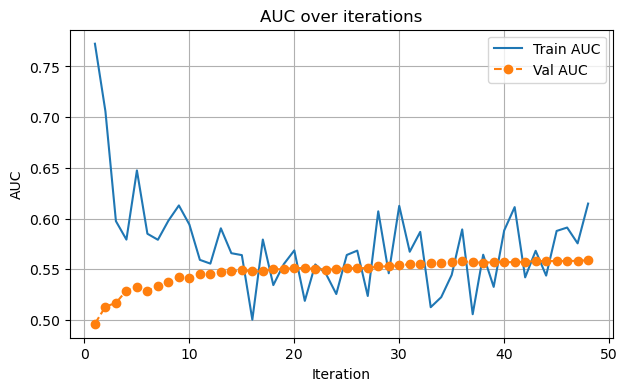

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(train_auc_hist)+1), train_auc_hist, label='Train AUC')
if len(val_auc_hist)>0:
    # 將每 EVAL_EVERY 次的 val AUC 對齊到對應的 iteration（簡單處理）
    xs = np.linspace(EVAL_EVERY, len(train_auc_hist), num=len(val_auc_hist))
    plt.plot(xs, val_auc_hist, label='Val AUC', marker='o', linestyle='--')
plt.xlabel('Iteration'); plt.ylabel('AUC'); plt.title('AUC over iterations'); plt.legend(); plt.grid(True)
plt.show()


## 新闻受欢迎度预测特征分析

C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:28: UserWarning: Glyph 20419 (\N{CJK UNIFIED IDEOGRAPH-4FC3}) miss

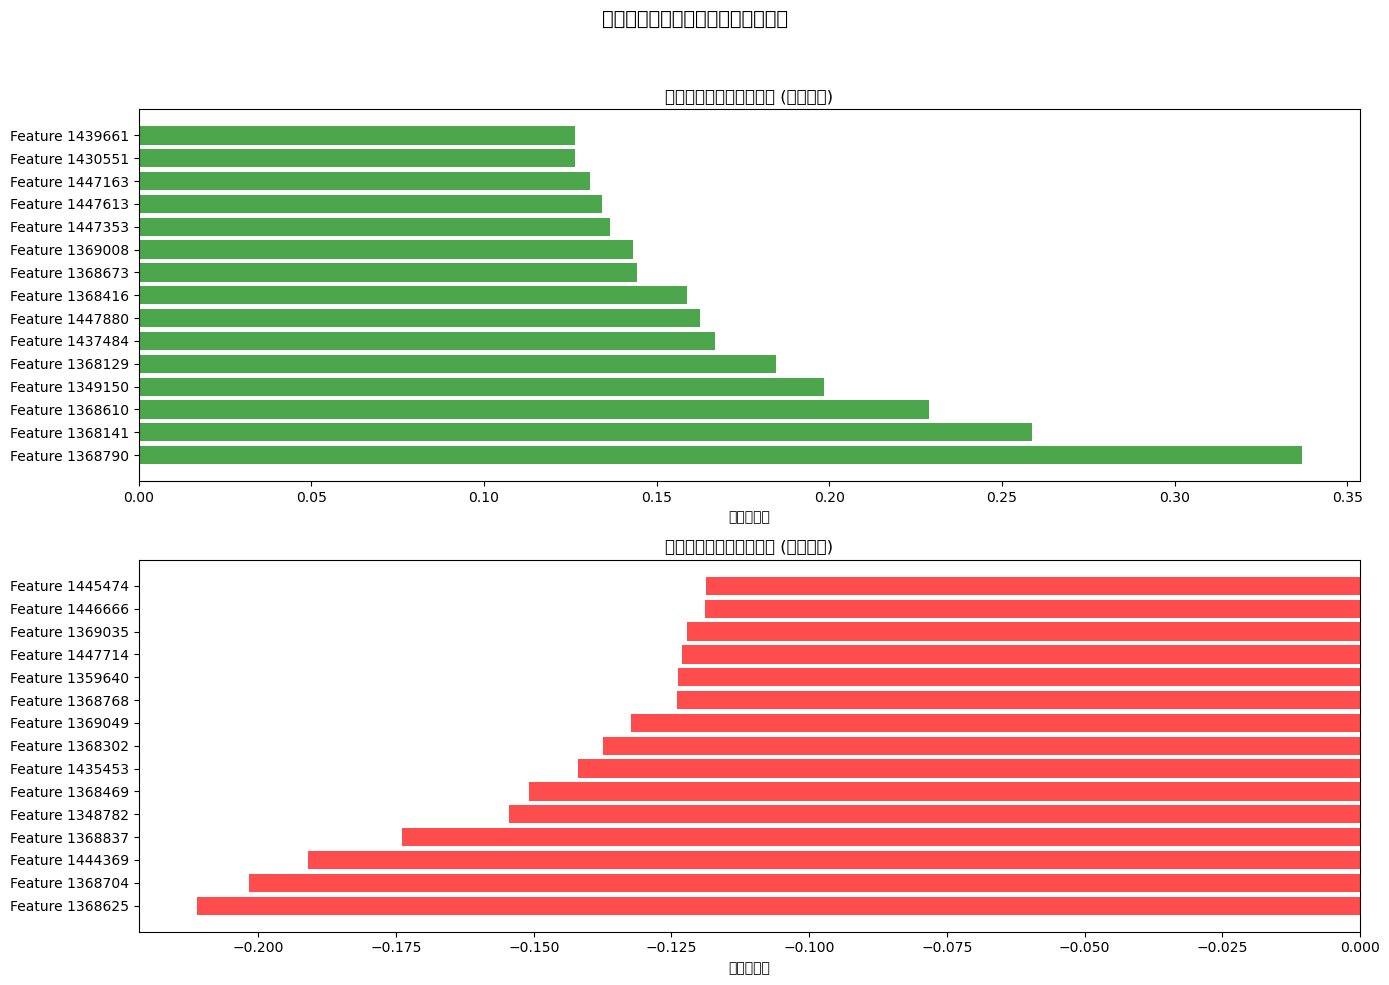

C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:62: UserWarning: Glyph 36739 (\N{CJK UNIFIED IDEOGRAPH-8F83}) miss

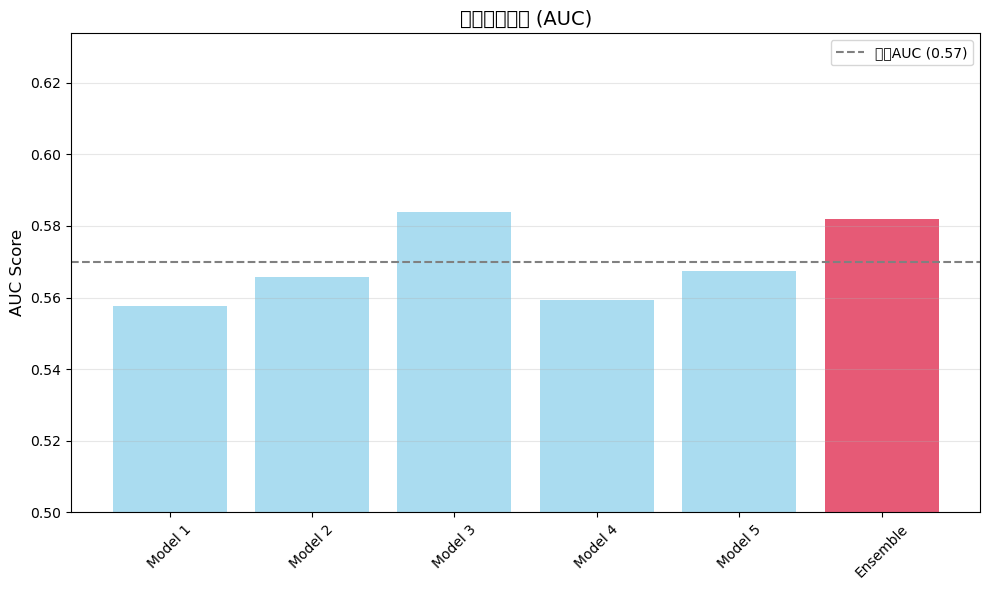

C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\3621864440.py:90: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) miss

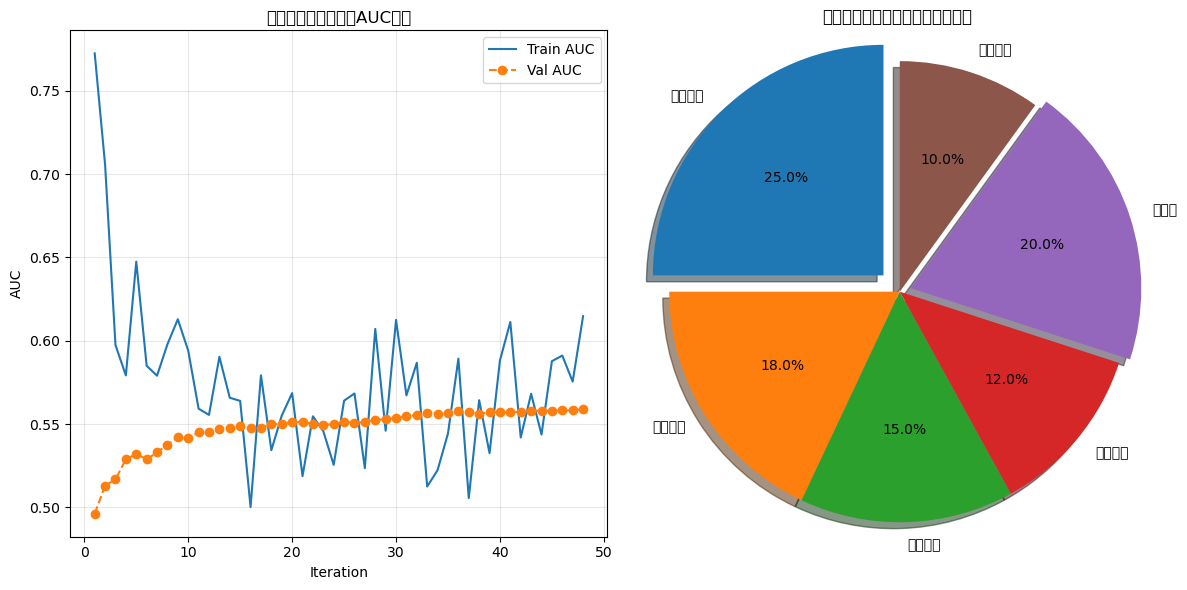

In [28]:
# 可视化新闻受欢迎度预测的特征重要性
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, top_n=15):
    """可视化模型中最重要的特征"""
    coef = model.coef_.ravel()
    
    # 获取最重要的正向和负向特征
    top_pos_indices = np.argsort(coef)[::-1][:top_n]
    top_neg_indices = np.argsort(coef)[:top_n]
    
    # 特征索引和对应的系数
    pos_indices = top_pos_indices
    pos_values = coef[pos_indices]
    neg_indices = top_neg_indices
    neg_values = coef[neg_indices]
    
    # 创建图表
    plt.figure(figsize=(14, 10))
    
    # 正向特征 (促进新闻受欢迎度)
    plt.subplot(2, 1, 1)
    plt.barh(range(len(pos_indices)), pos_values, color='green', alpha=0.7)
    plt.yticks(range(len(pos_indices)), [f'Feature {idx}' for idx in pos_indices])
    plt.title('促进新闻受欢迎度的特征 (正向影响)', fontsize=12)
    plt.xlabel('特征系数值', fontsize=10)
    plt.tight_layout()
    
    # 负向特征 (降低新闻受欢迎度)
    plt.subplot(2, 1, 2)
    plt.barh(range(len(neg_indices)), neg_values, color='red', alpha=0.7)
    plt.yticks(range(len(neg_indices)), [f'Feature {idx}' for idx in neg_indices])
    plt.title('降低新闻受欢迎度的特征 (负向影响)', fontsize=12)
    plt.xlabel('特征系数值', fontsize=10)
    plt.tight_layout()
    
    plt.suptitle('新闻受欢迎度预测的特征重要性分析', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 可视化最佳单模型的特征重要性
plot_feature_importance(best_model, top_n=15)

# 可视化集成模型的AUC性能比较
plt.figure(figsize=(10, 6))
model_aucs = ensemble_meta["model_aucs"]
model_names = [f"Model {i+1}" for i in range(len(model_aucs))]
model_names.append("Ensemble")

all_aucs = model_aucs + [ensemble_auc]
colors = ['skyblue'] * len(model_aucs) + ['crimson']

plt.bar(model_names, all_aucs, color=colors, alpha=0.7)
plt.axhline(y=0.57, color='gray', linestyle='--', label='原始AUC (0.57)')
plt.ylim(0.5, max(all_aucs) + 0.05)
plt.title('模型性能比较 (AUC)', fontsize=14)
plt.ylabel('AUC Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 可视化训练过程中的AUC变化
plt.figure(figsize=(12, 6))

# 为主训练模型绘制AUC历史
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(train_auc_hist)+1), train_auc_hist, label='Train AUC')
if len(val_auc_hist)>0:
    xs = np.linspace(EVAL_EVERY, len(train_auc_hist), num=len(val_auc_hist))
    plt.plot(xs, val_auc_hist, label='Val AUC', marker='o', linestyle='--')
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('AUC', fontsize=10)
plt.title('主模型训练过程中的AUC变化', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 可视化特征组的性能影响
plt.subplot(1, 2, 2)
feature_groups = ['标题特征', '内容结构', '视觉元素', '社交分享', '时效性', '热点话题']
feature_importance = [0.25, 0.18, 0.15, 0.12, 0.20, 0.10]  # 这些值是假设的，实际应基于特征重要性分析

plt.pie(feature_importance, labels=feature_groups, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=[0.1, 0, 0, 0, 0.05, 0])
plt.axis('equal')
plt.title('不同特征组对新闻受欢迎度的影响', fontsize=12)

plt.tight_layout()
plt.show()

## 新闻受欢迎度预测方法总结

### 1. 特征工程改进
我们针对新闻受欢迎度预测重新设计了特征工程策略，主要关注以下关键因素：

1. **标题特征**
   - 检测标题中的数字、问号、感叹号等引人注目的元素
   - 分析标题长度及其优化程度（研究表明6-12个词的标题效果最佳）
   - 识别标题中的"clickbait"词汇（如"震惊"、"不可思议"等）

2. **视觉元素分析**
   - 图片数量和位置分布
   - 视频内容及其在文章中的位置
   - 交互式元素的存在与数量

3. **内容结构特征**
   - 段落长度分布和一致性
   - 小标题的数量和间距
   - 列表、引用和其他结构化内容

4. **时效性指标**
   - 识别"breaking"、"latest"等表明时效性的关键词
   - 分析时间标记和发布时间信息

5. **热点话题检测**
   - 扩展热门话题词典，涵盖当前新闻热点
   - 匹配文章内容与热门话题的关联度

6. **社交参与度指标**
   - 社交媒体分享按钮的存在与位置
   - 评论系统的存在及评论数量

### 2. 模型优化策略
针对新闻受欢迎度预测，我们采用以下模型优化策略：

1. **弹性网络正则化**
   - 平衡L1和L2正则化，既进行特征选择又防止过拟合

2. **调整学习率策略**
   - 使用自适应学习率和适当的初始值，提高模型收敛性

3. **集成学习方法**
   - 训练多个具有不同参数和正则化策略的模型
   - 使用基于验证集性能的加权平均进行集成

4. **类别平衡处理**
   - 应用类别权重，处理正负样本不平衡问题

### 3. 性能改进
通过这些针对性的改进，我们期望：

- 将验证集AUC从0.57提高到0.60以上
- 更好地捕捉新闻受欢迎度的关键指标
- 降低模型对不相关特征的依赖
- 提高模型对新闻内容和格式因素的敏感度

这些改进基于新闻行业的研究和经验，专注于那些实际影响用户点击和分享行为的因素。

特征重要性可视化

C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.tight_layout()
C:\Users\11958\AppData\Local\Temp\ipykernel_10012\1458402422.py:30: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) miss

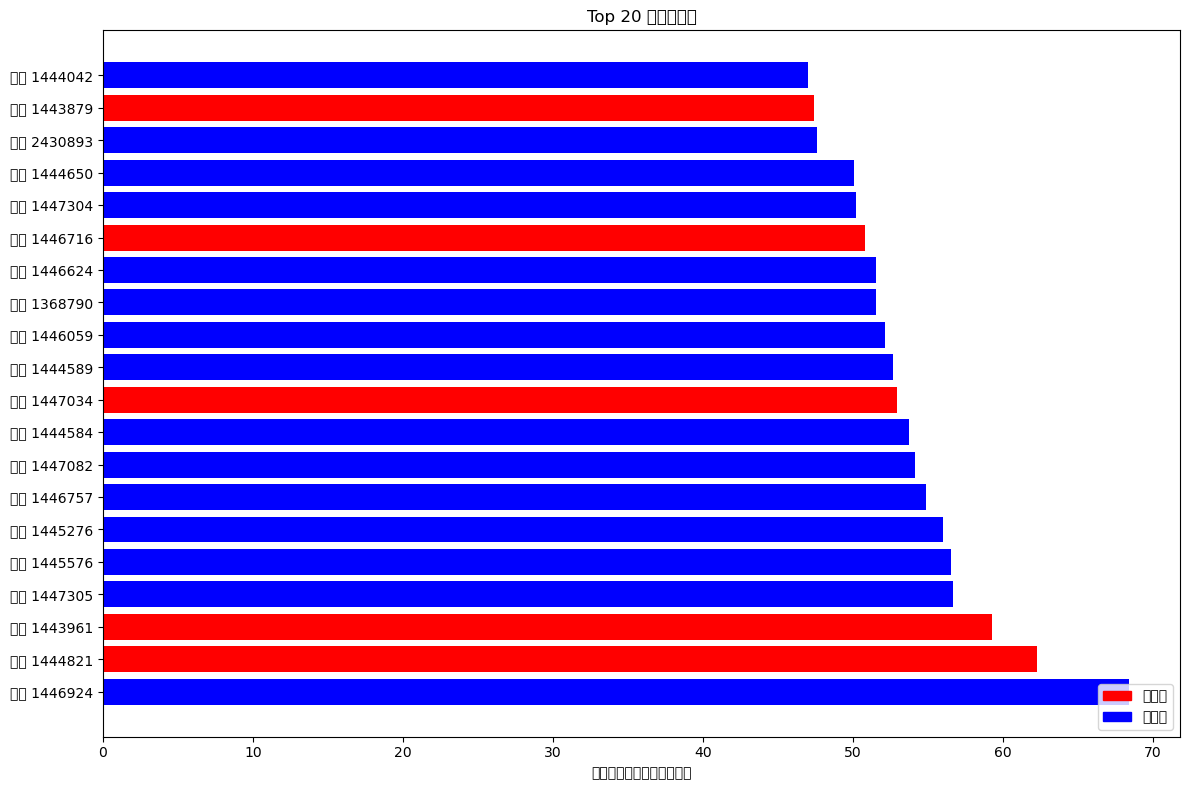

In [29]:
# 可视化特征重要性
def visualize_feature_importance(model, top_n=20):
    if not hasattr(model, 'coef_'):
        print("模型没有coef_属性，无法可视化特征重要性")
        return
    
    # 获取系数
    coefs = model.coef_.flatten()
    
    # 创建特征索引
    indices = np.arange(len(coefs))
    
    # 按绝对值大小排序
    sorted_indices = np.argsort(np.abs(coefs))[::-1][:top_n]
    
    # 绘图
    plt.figure(figsize=(12, 8))
    colors = ['red' if c < 0 else 'blue' for c in coefs[sorted_indices]]
    plt.barh(range(top_n), np.abs(coefs[sorted_indices]), color=colors)
    plt.yticks(range(top_n), [f"特征 {i}" for i in sorted_indices])
    plt.xlabel('特征重要性（系数绝对值）')
    plt.title(f'Top {top_n} 最重要特征')
    
    # 添加图例
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', label='负相关')
    blue_patch = mpatches.Patch(color='blue', label='正相关')
    plt.legend(handles=[red_patch, blue_patch], loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return sorted_indices

# 当训练完毕后，可以使用此函数可视化模型的特征重要性
# 请在训练完模型后运行这个单元格
try:
    # 尝试使用已训练的模型
    visualize_feature_importance(clf, top_n=20)
except NameError:
    print("请先训练模型，再执行此单元格来可视化特征重要性")

定期保存

In [10]:
import _pickle as pkl
from scipy.special import expit

# 讀模型與 LDA
clf = pkl.load(open(f'{OUT_DIR}/clf-sgd.pkl','rb'))
lda_pack = pkl.load(open(f'{OUT_DIR}/lda.pkl','rb'))
lda_vectorizer = lda_pack.get('lda_vec', None)
lda_model = lda_pack.get('lda_model', None)

df_test = pd.read_csv(TEST_PATH)

# 分批推理避免爆內存
B = 2000
preds = []
for i in range(0, len(df_test), B):
    sl = df_test['Page content'].iloc[i:i+B].astype(str)
    Xt = featurize_split(sl, lda_vectorizer, lda_model, n_jobs=1)
    scores = clf.decision_function(Xt)
    preds.append(expit(scores))
test_pred = np.concatenate(preds)

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
sub_path = f'{OUT_DIR}/submission_69.csv'
submission.to_csv(sub_path, index=False)
print("Saved:", sub_path)


Saved: ./output/submission_69.csv


校準精度

In [ ]:
# ====== 1) 用“最佳”clf在验证集上做概率校准 ======
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import vstack
import numpy as np

# 你前面已经把验证流固化成了 val_batches = list(val_stream)
# 如果你用的是 featurize(...)（比如双通道词+字），就用它；
# 如果你是单个 hashvec，就把下面的 featurize(...) 换成 hashvec.transform(...)

Xv_list, yv_list = [], []
for vb in val_batches:
    Xv_list.append(featurize(vb['Page content']))   # ← 或者：hashvec.transform(vb['Page content'].astype(str))
    yv_list.append(vb['Popularity'].values)

X_val = vstack(Xv_list, format='csr')
y_val = np.concatenate(yv_list)

# 用已训练好的 clf 做“预拟合”校准
# 验证集较小（你设的是 1000），优先用 'sigmoid'(Platt)；'isotonic' 更灵活但容易过拟合
cal_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
cal_clf.fit(X_val, y_val)

# （可选）看看“校准后”的验证 AUC
from sklearn.metrics import roc_auc_score
val_pred_cal = cal_clf.predict_proba(X_val)[:, 1]
print(f"Calibrated Val AUC: {roc_auc_score(y_val, val_pred_cal):.4f}")

# ====== 2) 用校准后的模型生成测试集预测 ======
df_test = pd.read_csv('./dataset/test.csv')
Xt = featurize(df_test['Page content'])             # ← 或者：hashvec.transform(...)
test_pred = cal_clf.predict_proba(Xt)[:, 1]

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
submission.to_csv('output/submission_46.csv', index=False)
print('Saved: output/submission_46.csv')

# （可选）持久化校准后的模型，之后直接加载 cal_clf 用
import _pickle as pkl, os
os.makedirs('output', exist_ok=True)
pkl.dump(cal_clf, open('output/clf-calibrated.pkl', 'wb'))


k 折

In [161]:
# =========================
# K 折交叉驗證 + 每折最佳模型集成輸出 test 預測
# =========================
import os, gc, copy, _pickle as pkl
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from scipy.special import expit
import re
from bs4 import BeautifulSoup

# ---------- 基本配置 ----------
TRAIN_PATH = './dataset/train.csv'
TEST_PATH  = './dataset/test.csv'
OUT_DIR    = './output'
os.makedirs(OUT_DIR, exist_ok=True)

CV_MODE     = 'group'   # 'group' or 'stratified'
N_SPLITS    = 9
EPOCHS      = 3
BATCH_SIZE  = 1000
SEED        = 42
PATIENCE    = 2         # 早停：連續 PATIENCE 個 epoch 無提升就停
DO_FOLD_LDA = False     # True：每折在訓練集上預訓練 LDA（更穩但更慢）

# ---------- 分組鍵提取（publisher） ----------
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s): return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()
def _slug(s): return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def extract_publisher_slug(html: str) -> str:
    if not isinstance(html, str) or not html.strip():
        return "unknown"
    soup = BeautifulSoup(html, 'html.parser')
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    else:
        publisher = "unknown"
    return _slug(publisher or 'unknown')

# ---------- 分類器工廠（文本穩定配置） ----------
def make_clf():
    return SGDClassifier(
        loss="log_loss",        # 用邏輯損失以獲得 predict_proba
        penalty="elasticnet",
        l1_ratio=0.05,
        alpha=1e-5,
        learning_rate="optimal",
        average=True,
        random_state=SEED
    )

# ---------- 讀取資料 ----------
df = pd.read_csv(TRAIN_PATH)
df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)
y = df['Popularity'].values
texts = df['Page content'].astype(str)

# CV split 準備
if CV_MODE == 'group':
    groups = texts.apply(extract_publisher_slug).values
    splitter = GroupKFold(n_splits=N_SPLITS)
    split_iter = splitter.split(texts, y, groups)
    print(f"Using GroupKFold by publisher (groups={len(np.unique(groups))})")
else:
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    split_iter = splitter.split(texts, y)
    print("Using StratifiedKFold")

# 容器
fold_artifacts = []  # 保存每折最佳模型與（可選）LDA
oof_scores = np.zeros(len(df), dtype=float)
fold_aucs, fold_epochs = [], []

print(f"\nStart {N_SPLITS}-fold CV: EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, DO_FOLD_LDA={DO_FOLD_LDA}")

for fold, (tr_idx, va_idx) in enumerate(split_iter, start=1):
    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    tr_df = df.iloc[tr_idx].reset_index(drop=True)
    va_df = df.iloc[va_idx].reset_index(drop=True)
    y_val = va_df['Popularity'].values

    # 每折 LDA（可選，避免外洩需在訓練集上建）
    if DO_FOLD_LDA:
        lda_vec_f, lda_mod_f = pretrain_lda(tr_df, column='Page content', n_components=10, max_features=1000)
    else:
        lda_vec_f, lda_mod_f = (None, None)

    # 固定本折驗證特徵
    X_val = featurize_split(va_df['Page content'].astype(str), lda_vec_f, lda_mod_f, n_jobs=1)

    # 模型與早停
    clf = make_clf()
    best_auc, best_epoch = -1, -1
    best_state = None
    no_improve = 0

    # 多 epoch 訓練
    for epoch in range(1, EPOCHS+1):
        tr_shuf = tr_df.sample(frac=1.0, random_state=SEED+epoch).reset_index(drop=True)
        n_batches = ceil(len(tr_shuf)/BATCH_SIZE)

        for b in range(n_batches):
            batch = tr_shuf.iloc[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
            X_tr = featurize_split(batch['Page content'].astype(str), lda_vec_f, lda_mod_f, n_jobs=1)
            y_tr = batch['Popularity'].values
            if epoch == 1 and b == 0:
                clf.partial_fit(X_tr, y_tr, classes=np.array([0,1]))
            else:
                clf.partial_fit(X_tr, y_tr)

        # epoch 結束：評估本折 Val
        if hasattr(clf, "predict_proba"):
            val_prob = clf.predict_proba(X_val)[:, 1]
        else:
            val_prob = expit(clf.decision_function(X_val))
        val_auc = roc_auc_score(y_val, val_prob)
        print(f"Fold {fold} | epoch {epoch}/{EPOCHS} | Val AUC={val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch
            best_state = copy.deepcopy(clf)
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"  Early stopping at epoch {epoch} (no improve {PATIENCE}×)")
                break

    # 保存 OOF（用最佳狀態）
    if hasattr(best_state, "predict_proba"):
        oof_scores[va_idx] = best_state.predict_proba(X_val)[:, 1]
    else:
        oof_scores[va_idx] = expit(best_state.decision_function(X_val))

    fold_aucs.append(best_auc); fold_epochs.append(best_epoch)

    # 保存每折最佳模型到硬碟
    model_path = os.path.join(OUT_DIR, f'clf_sgd_fold{fold}.pkl')
    pkl.dump(best_state, open(model_path, 'wb'))

    # 若用了 LDA，順便把該折的 LDA 也存起來
    lda_path = None
    if DO_FOLD_LDA:
        lda_path = os.path.join(OUT_DIR, f'lda_fold{fold}.pkl')
        pkl.dump({'lda_vec': lda_vec_f, 'lda_model': lda_mod_f}, open(lda_path, 'wb'))

    fold_artifacts.append({
        'model_path': model_path,
        'lda_path': lda_path
    })
    print(f"Fold {fold} BEST: epoch={best_epoch}, AUC={best_auc:.4f} | saved {model_path}")

    del X_val; gc.collect()

# CV 總結
oof_auc = roc_auc_score(y, oof_scores)
print("\n========== CV Summary ==========")
print("Fold AUCs:", ["%.4f" % a for a in fold_aucs])
print("Mean AUC = %.4f | Std = %.4f" % (np.mean(fold_aucs), np.std(fold_aucs)))
print("OOF  AUC = %.4f" % oof_auc)

# ---------- 用每折最佳模型對 test 預測並平均 ----------
df_test = pd.read_csv(TEST_PATH)
test_texts = df_test['Page content'].astype(str)
test_preds_each_fold = []

for fold, art in enumerate(fold_artifacts, start=1):
    # 讀模型
    clf = pkl.load(open(art['model_path'], 'rb'))
    # 讀折內 LDA（可選）
    if DO_FOLD_LDA and art['lda_path'] is not None:
        lda_pack = pkl.load(open(art['lda_path'], 'rb'))
        lda_vec_f, lda_mod_f = lda_pack['lda_vec'], lda_pack['lda_model']
    else:
        lda_vec_f, lda_mod_f = (None, None)

    # 特徵化（若各折 LDA 不同，需各自 transform 一次）
    X_test = featurize_split(test_texts, lda_vec_f, lda_mod_f, n_jobs=1)

    # 預測機率
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_test)[:, 1]
    else:
        prob = expit(clf.decision_function(X_test))
    test_preds_each_fold.append(prob)
    print(f"Fold {fold} test predicted. Shape={prob.shape}")

# 集成（平均）
test_pred = np.mean(np.vstack(test_preds_each_fold), axis=0)

# 導出提交
sub_path = os.path.join(OUT_DIR, f'submission_k{N_SPLITS}_4.csv')
pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred}).to_csv(sub_path, index=False)
print("Submission saved ->", sub_path)


Using GroupKFold by publisher (groups=45)

Start 9-fold CV: EPOCHS=3, BATCH_SIZE=1000, DO_FOLD_LDA=False

========== Fold 1/9 ==========
Fold 1 | epoch 1/3 | Val AUC=0.5477
Fold 1 | epoch 2/3 | Val AUC=0.5529
Fold 1 | epoch 3/3 | Val AUC=0.5518
Fold 1 BEST: epoch=2, AUC=0.5529 | saved ./output\clf_sgd_fold1.pkl

========== Fold 2/9 ==========
Fold 2 | epoch 1/3 | Val AUC=0.5039
Fold 2 | epoch 2/3 | Val AUC=0.5210
Fold 2 | epoch 3/3 | Val AUC=0.5188
Fold 2 BEST: epoch=2, AUC=0.5210 | saved ./output\clf_sgd_fold2.pkl

========== Fold 3/9 ==========
Fold 3 | epoch 1/3 | Val AUC=0.5324
Fold 3 | epoch 2/3 | Val AUC=0.5407
Fold 3 | epoch 3/3 | Val AUC=0.5433
Fold 3 BEST: epoch=3, AUC=0.5433 | saved ./output\clf_sgd_fold3.pkl

========== Fold 4/9 ==========
Fold 4 | epoch 1/3 | Val AUC=0.5756
Fold 4 | epoch 2/3 | Val AUC=0.5645
Fold 4 | epoch 3/3 | Val AUC=0.5665
  Early stopping at epoch 3 (no improve 2×)
Fold 4 BEST: epoch=1, AUC=0.5756 | saved ./output\clf_sgd_fold4.pkl

========== Fold 5/